# Notebook for ML project

In [1]:
#libreries
import h5py
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, fftfreq, fftshift
!{sys.executable} -m pip install tqdm
from tqdm import tqdm
import datetime
from time import perf_counter
from scipy.sparse.linalg import svds
from functionsvd import *

/bin/bash: {sys.executable}: command not found


In [2]:
#definition of variables

q = 10         # decimation factor
N = 2500     # number of samples to analyze
dt = 60          # number of minutes between samples
nt = int(6000/q) # Number of time steps in each sample
nx = 375         # Number of subsea channels at Whidbey
D = np.zeros((nx*nt,N))
t = []
start_time=datetime.datetime(2022, 7,10 , 0, 0, 0)

In [3]:
def fk_analysis(t0, draw_figure = True,downsamplefactor=q,cable = 'whidbey', record_length = 1,
               channel_range=[1225,1600]):
    
    
    prefix, network_name, datastore = data_wrangler(cable,record_length,t0)
    try:
        data,dates,attrs = open_sintela_file(prefix,
                                         t0,
                                         datastore,
                                         number_of_files=record_length,
                                         verbose=False)
    except:
        #print("error'ed out")
        return [np.nan], [np.nan], [np.nan]
    
    x1 = channel_range[0]
    x2 = channel_range[1]

    subsea_data = detrend(data[:,x1:x2])
    downsampled_subsea_data = subsea_data[::downsamplefactor,:]

    ft = fftshift(fft2(downsampled_subsea_data))
    f = fftshift(fftfreq(downsampled_subsea_data.shape[0], d=0.01 * downsamplefactor))
    k = fftshift(fftfreq(downsampled_subsea_data.shape[1], d=attrs['SpatialSamplingInterval']))
    
    return ft,f,k

In [4]:
#loop to read many files and calculate fk
#the variable this column is saving each ft 
#i is the contador of the loop
    nt = int(6000/q) # Number of time steps in each sample
    nx = 375 # Number of subsea channels at Whidbey
    #D is the matrix to save the data ft flatten, to build the column for one window
    D = np.zeros((nx*nt,N))
    t = []
    
    for i in tqdm(range(N)):
        this_time = start_time + i*datetime.timedelta(minutes=dt)
        t.append(this_time)
        ft,f,k = fk_analysis(this_time,draw_figure=False,downsamplefactor=q,
                            record_length = 1)
        if len(ft) == 1:
            continue

        shape = ft.shape
        this_nt = shape[0]
        this_nx = shape[1]

        if this_nt < nt:
            ft_new = np.zeros((nt,nx))
            ft_new[0:this_nt,0:nx] = np.abs(ft)
            this_column =  ft_new.flatten()
        elif this_nt > nt:
            ft_new = np.zeros((nt,nx))
            ft_new[0:nt,0:nx] = np.abs(ft[0:nt,0:nx])
            this_column =  ft_new.flatten()
        else:
            this_column = np.abs( ft.flatten() )

        D[:,i] = this_column
    t=np.array(t)
       

100%|██████████| 2500/2500 [17:03<00:00,  2.44it/s]


In [5]:
D.shape

(225000, 2500)

In [6]:
# Apply singular descomposition values
ns=N
U,S,V = svds( D[:,0:ns] )
 

In [7]:
U.shape
#singular value right side
t=np.array(t)

In [8]:
U.shape

(225000, 6)

In [9]:
#S is the diagnonal of the decomposition
S.shape
S

array([  872952.45083089,  1272421.41555459,  1411297.32475889,
        3839564.73816341,  5426924.87762227, 19766521.3669344 ])

In [10]:
V.shape 
#singularvalue right

(6, 2500)

In [11]:
#The column of U, allow us to choose which principal component were are looking at
#in this case is 1, but it could be from 0 to 5.
first_mode = U[:,1]

In [12]:
first_mode.shape


(225000,)

In [13]:
first_mode = np.abs(U[:,1].reshape((nt,nx))/np.max(np.abs(first_mode)))
first_time_series = V[1,:]

In [14]:
first_mode.shape

(600, 375)

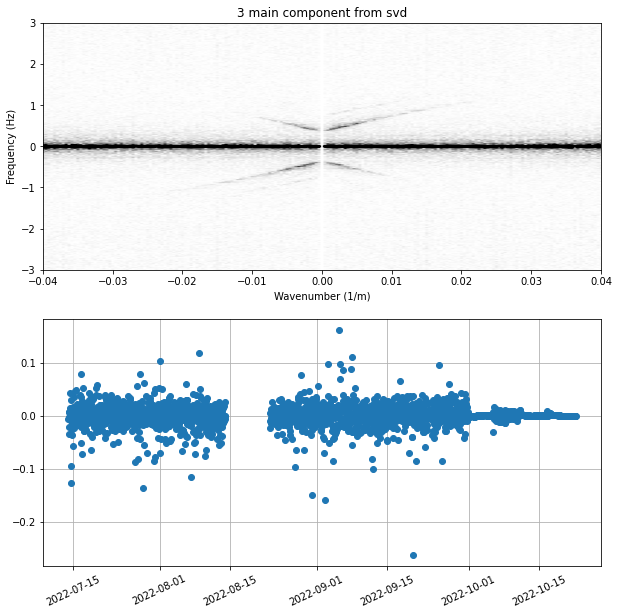

In [15]:
plt.subplots(2,1,figsize=(10,10))

ax1=plt.subplot(2,1,1)
#plt.title(f'Fraction of variance in 1st mode: {100*max(S)/sum(S)}%')
plt.title('3 main component from svd')
c=plt.imshow(first_mode,aspect='auto',vmin=0,vmax=0.1,extent=[k[0],k[-1],f[0],f[-1]],cmap='gray_r')

ax1.set_ylim([-3,3])
ax1.set_xlim([-0.04,0.04])
ax1.set_xlabel('Wavenumber (1/m)')
ax1.set_ylabel('Frequency (Hz)')
#     plt.colorbar()

ax2=plt.subplot(2,1,2)
ind = np.where(np.abs(first_time_series)>1e-10)
sign_change = np.sign(np.mean(first_time_series))
ax2.plot(t[ind],first_time_series[ind]*sign_change,'o')
plt.xticks(rotation = 25)
ax2.grid()


In [16]:
# Plotting eingvalues (S)
#Explained variance = the amount of variance explained by each of the selected components. 
explained_var = np.flip(S, 0)
normalized_ex_var = explained_var/sum(S)

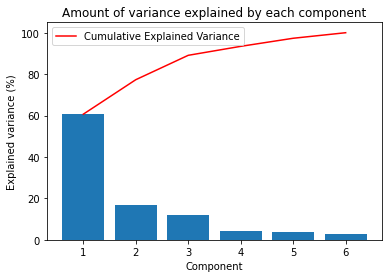

In [17]:
plt.bar(range(1,len(S)+1),normalized_ex_var*100)

plt.title("Amount of variance explained by each component")
plt.xlabel("Component")
plt.ylabel("Explained variance (%)")
plt.plot(range(1,len(explained_var)+1),
         np.cumsum(normalized_ex_var*100),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')